In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import spikeinterface as si
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages
import spikeinterface.extractors as se

In [2]:
spike_inf = pd.read_csv("/media/ubuntu/sda/data/mouse6/output/03_single_neuron/spike_inf_refine.tsv", sep = '\t')
cluster_inf = pd.read_csv("/media/ubuntu/sda/data/mouse6/output/03_single_neuron/cluster_inf_refine.tsv", sep = '\t')

trigger_time = pd.read_csv("/media/ubuntu/sda/data/mouse6/output/03_single_neuron/trigger_time_refine.csv")

In [3]:
used_neurons = ['Neuron_1', 'Neuron_2', 'Neuron_3', 'Neuron_4',
                'Neuron_7', 'Neuron_9', 'Neuron_11', 'Neuron_14',
                'Neuron_15', 'Neuron_16', 'Neuron_17', 'Neuron_18', 
                'Neuron_19', 'Neuron_20', 'Neuron_22', 'Neuron_23',
                'Neuron_24', 'Neuron_25']
date_order = ['021322', '022522', '031722', '042422', 
              '052422', '062422', '072322', '082322', 
              '092422', '102122', '112022', '122022', 
              '012123', '022223', '032123', '042323']

In [45]:
def get_spike_waveforms(spikes, results_dir, bfile=None, chan=None):
        from kilosort import io
        """Get waveform for each spike in `spikes`, multi- or single-channel.
        
        Parameters
        ----------
        spikes : list or array-like
            Spike times (in units of samples) for the desired waveforms, from
            `spike_times.npy`.
        results_dir : str or Path
            Path to directory where Kilosort4 sorting results were saved.
        bfile : kilosort.io.BinaryFiltered; optional
            Kilosort4 data file object. By default, this will be loaded using the
            information in `ops.npy` in the saved results.
        chan : int; optional.
            Channel to use for single-channel waveforms. If not specified, all
            channels will be returned.

        Returns
        -------
        waves : np.ndarray
            Array of spike waveforms with shape `(nt, len(spikes))`.
        
        """
        if isinstance(spikes, int):
            spikes = [spikes]

        if bfile is None:
            ops = io.load_ops(results_dir + '/ops.npy')
            bfile = io.bfile_from_ops(ops)
        whitening_mat_inv = np.load(results_dir + '/whitening_mat_inv.npy')

        waves = []
        for t in spikes:
            tmin = t - bfile.nt0min
            tmax = t + (bfile.nt - bfile.nt0min)
            w = bfile[tmin:tmax].cpu().numpy()
            if whitening_mat_inv is not None:
                w = whitening_mat_inv @ w
            if w.shape[1] == bfile.nt:
                # Don't include spikes at the start or end of the recording that
                # get truncated to fewer time points.
                waves.append(w)
        waves = np.stack(waves, axis=-1)

        if chan is not None:
            waves = waves[chan,:]
        
        bfile.close()

        return waves

In [6]:
for i in cluster_inf[cluster_inf['probe_group'] == 1].index:
    cluster_inf.at[i, 'best_six_chans'] = [1, 3, 5, 7, 9, 11]
for i in cluster_inf[cluster_inf['probe_group'] == 2].index:
    cluster_inf.at[i, 'best_six_chans'] = [13, 15, 17, 19, 21, 23]
for i in cluster_inf[cluster_inf['probe_group'] == 3].index:
    cluster_inf.at[i, 'best_six_chans'] = [24, 25, 26, 27, 28, 29]
for i in cluster_inf[cluster_inf['probe_group'] == 4].index:
    cluster_inf.at[i, 'best_six_chans'] = [12, 14, 16, 18, 20, 22]
for i in cluster_inf[cluster_inf['probe_group'] == 5].index:
    cluster_inf.at[i, 'best_six_chans'] = [0, 2, 4, 6, 8, 10]

In [9]:
waveform_dict = {}
for date in date_order:
    waveform_dict[date] = {}
    spike_inf_date = spike_inf[spike_inf['date'] == int(date)]
    for neuron in used_neurons:
        temp = spike_inf_date[spike_inf_date['Neuron'] == neuron]
        best_chan = cluster_inf.loc[(cluster_inf['date'] == int(date)) & (cluster_inf['Neuron'] == neuron), 'best_six_chans'].iloc[0]
        waveform_dict[date][neuron] = get_spike_waveforms(spikes=list(temp['time']), results_dir=f"/media/ubuntu/sda/data/mouse6/output/00_sort_result/{date}//kilosort4/sorter_output", chan=best_chan)

In [8]:
waveform_mean_dict = {}
for date in date_order:
    waveform_mean_dict[date] = {}
    for neuron in used_neurons:
        waveform_mean_dict[date][neuron] = np.mean(waveform_dict[date][neuron], axis=2)

KeyError: 'Neuron_1'

KeyError: 'Neuron_1'

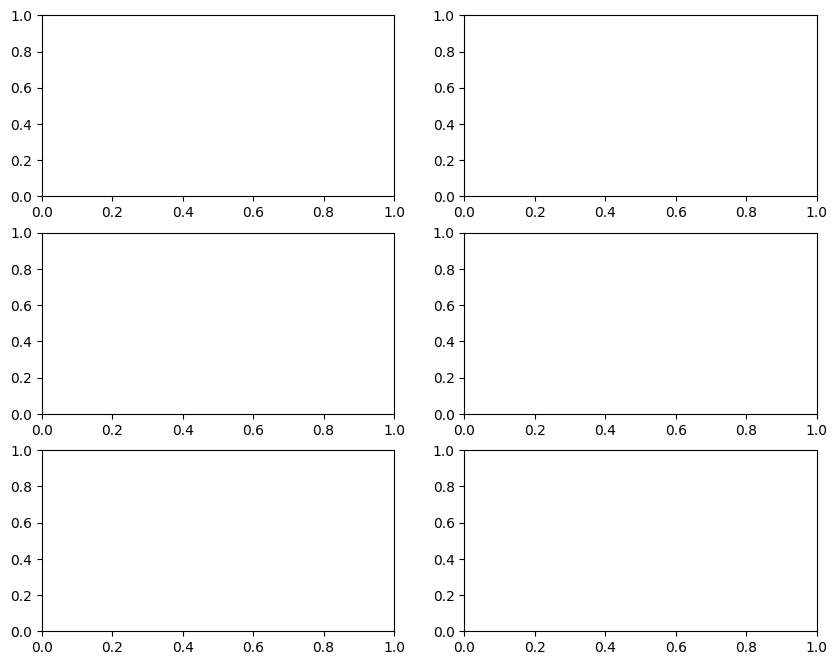

In [10]:
with PdfPages('waveform_mean.pdf') as pdf:
    for date in date_order:
        for neuron in used_neurons:
            fig, axes = plt.subplots(3, 2, figsize = (10, 8))
            axes = axes.flatten()
            
            max = waveform_mean_dict[date][neuron].max()
            min = waveform_mean_dict[date][neuron].min()

            for i in range(6):
                ax = axes[i]
                sns.lineplot(x = range(61),
                             y = waveform_mean_dict[date][neuron][i, :],
                             ax=ax)
            ax.set_ylim(min, max)
            fig.suptitle(f'{date}_{neuron}')
            pdf.savefig(figure=fig)
            plt.close(fig=fig)

- get segementation

In [ ]:
seg = {}

for date in date_order:
    seg[date] = {}
    trigger_time_temp = trigger_time[trigger_time['date'] == int(date)]
    for image in trigger_time_temp['order'].unique():
        seg[date][image] = np.zeros((30, 5000))
        start = trigger_time_temp.loc[trigger_time_temp['order'] == image, 'start'].iloc[0]
        end = trigger_time_temp.loc[trigger_time_temp['order'] == image, 'end'].iloc[0] + 5000
        temp = spike_inf[(spike_inf['date'] == int(date)) & (spike_inf['time'] >= start) & (spike_inf['time'] < end)]
        waveform = get_spike_waveforms(spikes=list(temp['time']), results_dir=f"/media/ubuntu/sda/data/mouse6/output/00_sort_result/{str(date)}//kilosort4/sorter_output", chan=temp['best_chans'].iloc[0])
        temp['time'] = temp['time'] - start
        temp.index = range(len(temp))

        for idx, row in temp.iterrows():
            time = row['time']
            best_chan_single = row['best_chans']
            wave = waveform[:, :, idx]
            start_time = np.maximum(0, time - 30)
            end_time = np.minimum(5000, time + 31)

            time_range = end_time - start_time
            if time_range < 61:
                wave = wave[:, :time_range]

            seg[date][image][best_chan_single, start_time:end_time] += wave

        


- cluster similarity

In [13]:
waveform_dict = {}
for date in date_order:
    waveform_dict[date] = {}
    spike_inf_date = spike_inf[spike_inf['date'] == int(date)]
    for neuron in used_neurons:
        temp = spike_inf_date[spike_inf_date['Neuron'] == neuron]
        best_chan = cluster_inf.loc[(cluster_inf['date'] == int(date)) & (cluster_inf['Neuron'] == neuron), 'best_chans'].iloc[0]
        waveform_dict[date][neuron] = get_spike_waveforms(spikes=list(temp['time']), results_dir=f"/media/ubuntu/sda/data/mouse6/output/00_sort_result/{date}//kilosort4/sorter_output", chan=best_chan)

In [14]:
neuron_df = {}
for neuron in used_neurons:
    neuron_df[neuron] = pd.DataFrame()
    for date in date_order:
        temp = pd.DataFrame(waveform_dict[date][neuron].T)
        temp['date'] = date
        neuron_df[neuron] = pd.concat((neuron_df[neuron], temp), axis=0)

In [15]:
neuron_df_al = pd.DataFrame()
for neuron in used_neurons:
    temp = neuron_df[neuron]
    temp['Neuron'] = neuron
    neuron_df_al = pd.concat((neuron_df_al, temp), axis=0)

In [16]:
rainbow_colors = [
    '#e77888', '#e87b4d', '#cb8d42', '#b69844', '#a39e44', '#8da546',
    '#69ad47', '#5aae78', '#5aab93', '#5aaba4', '#5aa9b4', '#59a7c7',
    '#59a4e7', '#8c97ee', '#b389ed', '#d973ed', '#e470ce', '#e675ac'
]

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.mplot3d import Axes3D


with PdfPages("umap_3d.pdf") as pdf:
    scaler = StandardScaler()
    num = 0
    for neuron in used_neurons:
        reducer_image = umap.UMAP(n_components=2)  
        temp = neuron_df[neuron].sample(n=10000, replace=False).reset_index(drop=True) 
        feature = scaler.fit_transform(temp.iloc[:, :61])
        embedding_image = reducer_image.fit_transform(feature)
        
        temp['date_code'] = temp['date'].astype('category').cat.codes * 5
        
        date_means = temp.groupby('date_code').apply(lambda x: np.mean(embedding_image[x.index], axis=0)).reset_index()
        date_means.columns = ['date_code', 'mean_embedding']
        
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        scatter = ax.scatter(
            embedding_image[:, 0],
            embedding_image[:, 1],
            temp['date_code'],
            c = rainbow_colors[num],
            s=1  
        )
         
        for i in range(len(date_means) - 1):
            x1, y1 = date_means.iloc[i]['mean_embedding']
            z1 = date_means.iloc[i]['date_code']
            x2, y2 = date_means.iloc[i + 1]['mean_embedding']
            z2 = date_means.iloc[i + 1]['date_code']
            ax.plot([x1, x2], [y1, y2], [z1, z2], color=rainbow_colors[num], linestyle='-')    
        
        
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        ax.set_zlabel('Month')
        ax.set_xlim3d(-35, 35)
        ax.set_ylim3d(-35, 35)
        ax.set_zlim3d(0, 60)
        ax.grid(False)
        ax.set_facecolor('white')
        ax.set_title(f'UMAP Embedding for Neuron {neuron}')
        num += 1
        pdf.savefig()
        plt.close()

In [23]:
date_means

,date_code,mean_embedding
0,1,"[3.8584943, 7.201961]"
1,2,"[3.0967274, 7.2758102]"
2,3,"[3.5573537, 7.3152413]"
3,4,"[3.4946508, 7.301369]"
4,5,"[3.3543193, 7.278869]"
5,6,"[3.822366, 7.2237983]"
6,7,"[3.4998221, 7.187285]"
7,8,"[3.423241, 7.261267]"
8,9,"[3.543873, 7.311855]"
9,10,"[3.566071, 7.2561088]"


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages("umap_3d.pdf") as pdf:
    scaler = StandardScaler()
    
    for neuron in used_neurons:
        reducer_image = umap.UMAP(n_components=3)  # 设置 UMAP 的维度为 3
        temp = neuron_df[neuron].sample(n=10000, replace=False).reset_index(drop=True)
        feature = scaler.fit_transform(temp.iloc[:, :61])
        embedding_image = reducer_image.fit_transform(feature)
        
        # 将 date 转换为 1 到 16 的整数
        temp['date_code'] = temp['date'].astype('category').cat.codes + 1
        
        # 计算每个 date 的嵌入均值
        date_means = temp.groupby('date_code').apply(lambda x: np.mean(embedding_image[x.index], axis=0)).reset_index()
        date_means.columns = ['date_code', 'mean_embedding']
        
        
        # 创建三维图
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # 绘制散点图
        scatter = ax.scatter(
            embedding_image[:, 0],
            embedding_image[:, 1],
            embedding_image[:, 2],
            c=temp['date_code'],
            cmap='viridis',
            s=1  # 设置点的大小
        )
        
        # 绘制每个 date 的均值点
        for _, row in date_means.iterrows():
            ax.scatter(row['mean_embedding'][0], row['mean_embedding'][1], row['mean_embedding'][2], 
                       color='red', s=50, marker='x')  # 均值点用红色叉表示
        
        # 绘制连线
        for _, row in date_means.iterrows():
            ax.plot([row['mean_embedding'][0], row['mean_embedding'][0]],
                    [row['mean_embedding'][1], row['mean_embedding'][1]],
                    [embedding_image[:, 2].min(), row['mean_embedding'][2]],
                    color='red', linestyle='--')
        
        # 设置标签
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        ax.set_zlabel('UMAP 3')
        ax.set_title(f'UMAP Embedding for Neuron {neuron}')
        
        # 保存到 PDF
        pdf.savefig()
        plt.close()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,80.354118,-15.810730,-61.177505,-37.559410,-7.917671,-11.918694,-45.316929,-40.310295,28.317995,82.355431,...,5.582964,40.781662,5.093904,-71.778931,-53.111626,28.305763,50.309784,-17.250076,-25.574009,89.413445
1,-18.685360,16.693680,18.207067,-97.442627,-152.472504,-42.006710,101.523430,118.266968,68.367287,61.291336,...,49.913273,105.966560,86.905624,10.278008,-43.155712,-52.406925,-30.084225,-22.172068,-50.321995,-24.397804
2,30.401144,57.219196,38.345779,29.973557,39.553146,4.709590,-28.870598,3.439419,24.351934,10.840256,...,27.476204,12.222373,11.382203,-3.263802,-18.859991,-34.667168,-31.220737,-36.711353,-39.645645,-34.240433
3,33.675041,23.018877,17.341299,15.966826,24.410389,12.995847,-2.703302,10.973028,31.553993,66.381477,...,-86.001892,-42.353394,34.178192,-4.234744,-112.846413,-133.810135,-46.732471,36.949940,35.503754,9.901668
4,-27.942911,1.367368,6.701406,7.589922,-6.404304,-21.747398,0.732933,7.094762,-14.045293,-34.030174,...,-24.091885,-4.366300,14.349302,19.287342,-8.237705,-32.614128,-43.729301,-17.769653,-6.968595,-22.963810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13440,36.965340,-13.782556,-29.882261,-39.545921,-46.829075,-22.313398,24.150814,0.415737,-106.596031,-41.128567,...,60.054642,80.791229,38.919937,5.409003,6.846199,-28.530769,-40.315746,-30.820950,-6.226972,55.705616
13441,-6.207428,7.508578,7.143088,21.408876,30.271893,35.329197,35.769997,5.092466,-3.095938,3.278762,...,19.719776,8.615266,-8.322742,-14.201447,12.282602,34.307762,-2.520501,-31.932713,-8.573754,-20.363028
13442,34.119110,58.795128,37.707901,28.535570,31.951614,-0.643148,-37.835850,-21.264620,7.259084,-6.609198,...,27.979849,51.646648,10.784683,-20.037224,-56.847988,-45.429127,-16.253641,14.183891,20.833046,-9.340410
13443,-21.156370,13.715923,29.023369,19.059683,63.770668,93.007027,19.745850,-38.259869,-25.411612,6.397540,...,-20.948063,2.848289,5.907777,-0.563488,-23.158373,-30.374489,-44.385395,-37.110474,-22.918379,-28.932259


In [5]:
import probeinterface as pi
from probeinterface.plotting import plot_probe_group
probe_30channel = pi.read_probeinterface("/media/ubuntu/sda/data/probe.json")

In [6]:
import spikeinterface.preprocessing as spre

record_dir = os.listdir("/media/ubuntu/sda/data/mouse6/ns4/natural_image")
for date in date_order:
    record = [s for s in record_dir if date in s][0]
    reocording = se.read_blackrock(f'/media/ubuntu/sda/data/mouse6/ns4/natural_image/{record}').remove_channels(["98", '31', '32'])
    reocording = reocording.set_probegroup(probe_30channel)
    reocording = spre.bandpass_filter(reocording, freq_min=300, freq_max=3000)
    reocording = spre.common_reference(reocording, reference="global", operator="median")
    trigger_temp = trigger_time[trigger_time['date'] == int(date)]
    for i in range(len(trigger_temp)):
        temp = reocording.get_traces(start_frame=trigger_temp.iloc[i, 1],
                                end_frame=trigger_temp.iloc[i, 2] + 5000)
        np.save(f'/media/ubuntu/sda/data/mouse6/output/04_get_neuron_channel/seg_all/seg_{date}_{trigger_temp.iloc[i, 5]}.npy', temp)
        

- firing rate

In [48]:
temp

,Unnamed: 0,cluster,position_1,position_2,templates,time,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,neuron,cluster_devide,date,cluster_date,Neuron,Neuron_index,neuron_date
0,155071,64,341.535187,477.115051,64,1685,-8.864556,2.572876,4.712470,-1.914687,-0.442591,-0.339469,NaN,64,21322,64_021322,Neuron_1,1,Neuron_1_021322
1,155096,64,344.190155,489.675659,64,1959,-7.687418,1.825408,1.905109,1.328057,0.038760,-3.602225,NaN,64,21322,64_021322,Neuron_1,1,Neuron_1_021322
2,155129,64,338.027222,485.210114,64,1279,-6.497515,4.959160,0.329921,-0.938013,-2.126357,-2.325914,NaN,64,21322,64_021322,Neuron_1,1,Neuron_1_021322
3,155186,64,329.440765,491.992035,64,8433,-7.388475,5.287142,1.664165,-1.345252,-1.061511,1.223624,NaN,64,21322,64_021322,Neuron_1,1,Neuron_1_021322
4,155196,64,337.018799,490.718445,64,7934,-9.948390,3.055974,1.290977,0.515553,-1.148991,0.830600,NaN,64,21322,64_021322,Neuron_1,1,Neuron_1_021322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,6628936,20,605.468262,7.847751,20,2113,-7.638821,-2.583167,-2.264166,-0.748487,-0.493668,0.030771,NaN,20,21322,20_021322,Neuron_25,53,Neuron_25_021322
211,6628939,20,613.051514,12.427107,20,2312,-10.682124,-0.022002,3.473084,-1.956735,2.053914,2.118306,NaN,20,21322,20_021322,Neuron_25,53,Neuron_25_021322
212,6628941,20,605.494080,4.595112,20,2548,-10.522643,1.334514,3.096858,0.032501,1.545786,-2.267043,NaN,20,21322,20_021322,Neuron_25,53,Neuron_25_021322
213,6628942,20,604.712891,12.685261,20,2610,-10.842591,-0.946094,-1.316194,0.074811,0.703329,-1.612410,NaN,20,21322,20_021322,Neuron_25,53,Neuron_25_021322


In [47]:
seg = {}

for date in date_order:
    seg[date] = {}
    trigger_time_temp = trigger_time[trigger_time['date'] == int(date)]
    for image in trigger_time_temp['order'].unique():
        seg[date][image] = np.zeros((30, 5000))
        start = trigger_time_temp.loc[trigger_time_temp['order'] == image, 'start'].iloc[0]
        end = trigger_time_temp.loc[trigger_time_temp['order'] == image, 'end'].iloc[0] + 5000
        temp = spike_inf[(spike_inf['date'] == int(date)) & (spike_inf['time'] >= start) & (spike_inf['time'] < end)]
        temp['time'] = temp['time'] - start
        temp.index = range(len(temp))

KeyboardInterrupt: 

In [ ]:
for neuron_idx, neuron in enumerate(spike_inf['Neuron'].unique()):

    neuron_df = spike_inf[spike_inf['Neuron'] == neuron]

    dates = trigger_time['date'].unique()
    date_indices = np.arange(len(dates))  

    spike_rates = []

    for date in dates:
        trigger_time_temp = trigger_time[(trigger_time['image'] == image) & (trigger_time['date'] == date)]
        all_spikes = []

        for index, row in trigger_time_temp.iterrows():
            start = row['expand_start'] - 15000
            end = row['expand_end'] - 5000

            filtered_spikes = neuron_df[(neuron_df['date'] == date) &
                                        (neuron_df['time'] >= start) &
                                        (neuron_df['time'] <= end)]

            if not filtered_spikes.empty:
                relative_spikes = filtered_spikes['time'] - start
                all_spikes.extend(relative_spikes)

        if all_spikes:
            time_bins = np.linspace(0, max(all_spikes), 100)
            spike_counts, _ = np.histogram(all_spikes, bins=time_bins)
            spike_rate = spike_counts / (time_bins[1] - time_bins[0])
            spike_rates.append(spike_rate)

(5000, 30)